# Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np
import math

# Database creations using pytorch Dataset 

In [2]:
class ImageQualityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None, quality=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            quality (string, optional): Filter by quality score ('low' for < 50, 'high' for >= 50).
        """
        # Load the full dataset first
        self.data = pd.read_csv(csv_file)
        
        median = self.data.iloc[:, 0].median()
        print("Median quality score: ", median)
        # Filter the dataset by quality if specified
        if quality is not None:
            if quality.lower() == 'low':
                # Filter for quality scores below 50
                self.data = self.data[self.data.iloc[:, 0] < median]  # Quality is in column 0
            elif quality.lower() == 'high':
                # Filter for quality scores above or equal to 50
                self.data = self.data[self.data.iloc[:, 0] >= median]  # Quality is in column 0
            else:
                raise ValueError("quality must be either 'low', 'high', or None")
        
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        quality = self.data.iloc[idx, 0]  # Quality column
        labels = torch.tensor([quality], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, labels

# Definitions of the models

In [3]:
class QualityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Predict quality and realness
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features

# Utility functions for training and evaluation

In [4]:
import time
import copy
from tqdm import tqdm


def train_model(model, dataloaders, criterion, optimizer, 
                min_epochs=10, max_epochs=100, patience=10, device='cuda'):
    """
    Trains the model with early stopping based on validation loss.
    
    Args:
        model (nn.Module): The model to train.
        dataloaders (dict): A dictionary containing the training and validation data loaders.
        criterion (nn.Module): The loss function.
        optimizer (optim.Optimizer): The optimizer.
        min_epochs (int): Minimum number of epochs to train for before applying early stopping. Defaults to 10.
        max_epochs (int): Maximum number of epochs to train for. Defaults to 100.
        patience (int): Number of epochs to wait for improvement before early stopping. Defaults to 10.
        device (str): Device to use for training ('cuda' or 'cpu'). Defaults to 'cuda'.
    
    Returns:
        nn.Module: The best model based on validation loss.
    """
    # Start timer to track total training time
    start_time = time.time()
    
    # Initialize variables for tracking best model
    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    no_improve_count = 0
    
    # History dictionary to store metrics for later analysis/plotting
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    # Move model to specified device
    model.to(device)
    print(f"Training on {device}")
    print(f"Minimum epochs: {min_epochs}, Maximum epochs: {max_epochs}")
    print(f"Early stopping patience: {patience}")
    
    # Main training loop
    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 40)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            
            # Use tqdm for a progress bar during training
            total_batches = len(dataloaders[phase])
            progress_bar = tqdm(dataloaders[phase], total=total_batches, 
                               desc=f'{phase.capitalize()}')
            
            # Iterate over data batches
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Update running loss and progress bar
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                progress_bar.set_postfix(loss=batch_loss/inputs.size(0))
            
            # Calculate epoch loss
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            # Store loss in history
            history[f'{phase}_loss'].append(epoch_loss)
            
            # Print phase results
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')
            
            # If in validation phase, check if this is the best model
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    # Update best validation loss and save best model weights
                    best_val_loss = epoch_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    no_improve_count = 0
                    print(f'New best validation loss: {best_val_loss:.4f}')
                else:
                    # Increment counter for early stopping
                    no_improve_count += 1
                    print(f'No improvement for {no_improve_count} epochs')
                    
                    # Check if we should stop training, but only after minimum epochs
                    if no_improve_count >= patience and epoch+1 >= min_epochs:
                        print(f'Early stopping triggered after {epoch+1} epochs')
                        # Break out of the epoch loop
                        break
        
        # Check if early stopping was triggered, but only after minimum epochs
        if no_improve_count >= patience and epoch+1 >= min_epochs:
            break
        
        print()  # Add empty line between epochs
    
    # Calculate total training time
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best validation loss: {best_val_loss:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, history
def test_model(model, dataloader, criterion, device='cuda'):

    """
    Tests the model on the test dataset.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The test data loader.
        criterion (nn.Module): The loss function.
        device (str): Device to use for testing ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        float: The average loss on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, _ = model(inputs)
            
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

    test_loss = math.sqrt(running_loss / len(dataloader.dataset))
    print(f'Test RMSE: {test_loss:.4f}')
    return test_loss

def get_predictions(model, dataloader, device)-> tuple[torch.Tensor, torch.Tensor]:
    """
    Get predictions from the model.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): The data loader.

    Returns:
        tuple: A tuple (predictions, labels) where:
            predictions (torch.Tensor): Predictions from the model.
            labels (torch.Tensor): Ground truth labels.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    predictions = []
    labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, target in dataloader:
            outputs, _ = model(inputs.to(device))
            predictions.append(outputs)
            labels.append(target)

    #move to cpu and concatenate
    predictions = torch.cat(predictions).cpu()
    labels = torch.cat(labels).cpu()

    return predictions, labels

def get_regression_errors(tuple: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Get regression errors.

    Args:
        tuple: A tuple (predictions, labels) where:
            predictions (torch.Tensor): Predictions from the model.
            labels (torch.Tensor): Ground truth labels.

    Returns:
        tuple: A tuple (quality_errors, authenticity_errors) where:
            quality_errors (torch.Tensor): Quality errors.
            authenticity_errors (torch.Tensor): Authenticity errors.
    """
    predictions, labels = tuple
    quality_errors = predictions[:, 0] - labels[:, 0]
    authenticity_errors = predictions[:, 1] - labels[:, 1]
    return quality_errors, authenticity_errors

def get_rmse(errors: torch.Tensor) -> torch.Tensor:
    """
    Get the root mean squared error.

    Args:
        errors (torch.Tensor): Errors.

    Returns:
        torch.Tensor: Root mean squared error.
    """
    return torch.sqrt(torch.mean(errors ** 2))


## Training section

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annotations_file = 'Dataset/AIGCIQA2023/mos_data.csv'

# Create the dataset
low_quality_dataset = ImageQualityDataset(csv_file=annotations_file, transform=data_transforms, quality='low')
high_quality_dataset = ImageQualityDataset(csv_file=annotations_file, transform=data_transforms, quality='high')

# # Set random seeds for reproducibility
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# np.random.seed(42)

# LOW QUALITY: Split the dataset into training, validation, and test sets
low_train_size = int(0.7 * len(low_quality_dataset))
low_val_size = int(0.2 * len(low_quality_dataset))
test_size = len(low_quality_dataset) - low_train_size - low_val_size
low_train_dataset, low_val_dataset, low_test_dataset = random_split(low_quality_dataset, [low_train_size, low_val_size, test_size])

# HIGH QUALITY: Split the dataset into training, validation, and test sets
high_train_size = int(0.7 * len(high_quality_dataset))
high_val_size = int(0.2 * len(high_quality_dataset))
test_size = len(high_quality_dataset) - high_train_size - high_val_size
hihg_train_dataset, hihg_val_dataset, hihg_test_dataset = random_split(high_quality_dataset, [high_train_size, high_val_size, test_size])

# print sizes of the datasets
print(f'Low quality dataset: {len(low_quality_dataset)}')
print(f'High quality dataset: {len(high_quality_dataset)}')


# Create data loaders
BATCH_SIZE = 64
MIN_EPOCHS = 20
MAX_EPOCHS = 100
PATIENCE = 10

# Low quality data loaders
low_train_dataloader = DataLoader(low_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
low_val_dataloader = DataLoader(low_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
low_test_dataloader = DataLoader(low_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# High quality data loaders
high_train_dataloader = DataLoader(hihg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
high_val_dataloader = DataLoader(hihg_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
high_test_dataloader = DataLoader(hihg_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# Create a dictionary containing the data loaders
low_dataloaders = {
    'train': low_train_dataloader,
    'val': low_val_dataloader,
    'test': low_test_dataloader
}

high_dataloaders = {
    'train': high_train_dataloader,
    'val': high_val_dataloader,
    'test': high_test_dataloader
}


model = QualityPredictor()
criterion = nn.MSELoss()  # Mean Squared Error Loss (regression)
optimizer = optim.Adam(model.regression_head.parameters(), lr=0.001)


Median quality score:  50.75346775059262
Median quality score:  50.75346775059262
Low quality dataset: 1200
High quality dataset: 1200


## Train 

In [6]:
LOW_QUALITY_MODEL_PATH = 'Models/VGG-16_low_quality_finetuned.pth'
HIGH_QUALITY_MODEL_PATH = 'Models/VGG-16_high_quality_finetuned.pth'

low_quality_predictor_trained, low_quality_training_history= train_model(model, low_dataloaders, criterion, optimizer, min_epochs=MIN_EPOCHS,max_epochs=MAX_EPOCHS, patience=PATIENCE, device=device)
torch.save(low_quality_predictor_trained.state_dict(), LOW_QUALITY_MODEL_PATH)

high_quality_predictor_trained, high_quality_training_history= train_model(model, high_dataloaders, criterion, optimizer, min_epochs=MIN_EPOCHS,max_epochs=MAX_EPOCHS, patience=PATIENCE, device=device)
torch.save(high_quality_predictor_trained.state_dict(), HIGH_QUALITY_MODEL_PATH)


Training on cuda
Minimum epochs: 20, Maximum epochs: 100
Early stopping patience: 10
Epoch 1/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, loss=245]   


Train Loss: 772.0384


Val: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s, loss=72.5]


Val Loss: 97.5860
New best validation loss: 97.5860

Epoch 2/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s, loss=105]


Train Loss: 173.8499


Val: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, loss=61.2]


Val Loss: 82.3747
New best validation loss: 82.3747

Epoch 3/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=106]


Train Loss: 115.6889


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=117]


Val Loss: 148.0732
No improvement for 1 epochs

Epoch 4/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s, loss=82.8]


Train Loss: 97.8609


Val: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, loss=70]  


Val Loss: 92.9350
No improvement for 2 epochs

Epoch 5/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, loss=72.1]


Train Loss: 90.1079


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=74.8]


Val Loss: 98.9101
No improvement for 3 epochs

Epoch 6/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=87]  


Train Loss: 90.5598


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=71]  


Val Loss: 95.0963
No improvement for 4 epochs

Epoch 7/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, loss=82.9]


Train Loss: 88.2463


Val: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, loss=68.1]


Val Loss: 92.6939
No improvement for 5 epochs

Epoch 8/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=19.1]


Train Loss: 79.6841


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=68.4]


Val Loss: 93.0185
No improvement for 6 epochs

Epoch 9/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=157] 


Train Loss: 75.3702


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=56.1]


Val Loss: 78.3595
New best validation loss: 78.3595

Epoch 10/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, loss=73.6]


Train Loss: 83.0490


Val: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s, loss=71.2]


Val Loss: 94.8385
No improvement for 1 epochs

Epoch 11/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=44.8]


Train Loss: 76.9230


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=64.4]


Val Loss: 86.5718
No improvement for 2 epochs

Epoch 12/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=86.3]


Train Loss: 69.9972


Val: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, loss=70.2]


Val Loss: 91.0809
No improvement for 3 epochs

Epoch 13/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, loss=38.3]


Train Loss: 73.0510


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=73.3]


Val Loss: 93.1309
No improvement for 4 epochs

Epoch 14/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s, loss=13.7]


Train Loss: 72.1081


Val: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, loss=68.1]


Val Loss: 86.9648
No improvement for 5 epochs

Epoch 15/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=104] 


Train Loss: 71.7018


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=66.9]


Val Loss: 86.3793
No improvement for 6 epochs

Epoch 16/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=50.2]


Train Loss: 66.8375


Val: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, loss=59]  


Val Loss: 78.9129
No improvement for 7 epochs

Epoch 17/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s, loss=142] 


Train Loss: 70.5069


Val: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, loss=74.2]


Val Loss: 96.2483
No improvement for 8 epochs

Epoch 18/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s, loss=87.2]


Train Loss: 74.6753


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=67.1]


Val Loss: 86.6641
No improvement for 9 epochs

Epoch 19/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=64.3]


Train Loss: 64.7977


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=57.2]


Val Loss: 77.3808
New best validation loss: 77.3808

Epoch 20/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=80.6]


Train Loss: 67.1610


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=55]  


Val Loss: 76.7848
New best validation loss: 76.7848

Epoch 21/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, loss=61.6]


Train Loss: 69.0551


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=68.7]


Val Loss: 91.6393
No improvement for 1 epochs

Epoch 22/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s, loss=39.9]


Train Loss: 66.7575


Val: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, loss=56.6]


Val Loss: 77.9029
No improvement for 2 epochs

Epoch 23/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s, loss=63.3]


Train Loss: 68.6612


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=60.9]


Val Loss: 81.3126
No improvement for 3 epochs

Epoch 24/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, loss=96.5]


Train Loss: 67.2608


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=66.6]


Val Loss: 87.6780
No improvement for 4 epochs

Epoch 25/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, loss=107] 


Train Loss: 69.3214


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=65.8]


Val Loss: 88.1979
No improvement for 5 epochs

Epoch 26/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=43.7]


Train Loss: 64.6199


Val: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s, loss=56.3]


Val Loss: 76.4276
New best validation loss: 76.4276

Epoch 27/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=64.1]


Train Loss: 68.5039


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=67]  


Val Loss: 86.9628
No improvement for 1 epochs

Epoch 28/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, loss=36]  


Train Loss: 68.8777


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=54.9]


Val Loss: 73.6074
New best validation loss: 73.6074

Epoch 29/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, loss=59.2]


Train Loss: 69.0760


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=66.2]


Val Loss: 85.8594
No improvement for 1 epochs

Epoch 30/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s, loss=79]  


Train Loss: 62.2144


Val: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, loss=64.2]


Val Loss: 81.5248
No improvement for 2 epochs

Epoch 31/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, loss=99.3]


Train Loss: 60.4023


Val: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, loss=65.7]


Val Loss: 84.9953
No improvement for 3 epochs

Epoch 32/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=20.4]


Train Loss: 63.2352


Val: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, loss=63.6]


Val Loss: 84.0526
No improvement for 4 epochs

Epoch 33/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, loss=143] 


Train Loss: 64.2125


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=58.2]


Val Loss: 76.6271
No improvement for 5 epochs

Epoch 34/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, loss=13.5]


Train Loss: 62.4988


Val: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s, loss=59.9]


Val Loss: 79.1012
No improvement for 6 epochs

Epoch 35/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, loss=52.5]


Train Loss: 67.4985


Val: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s, loss=60.9]


Val Loss: 83.0261
No improvement for 7 epochs

Epoch 36/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=67.8]


Train Loss: 67.1270


Val: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, loss=64]  


Val Loss: 86.2728
No improvement for 8 epochs

Epoch 37/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, loss=132] 


Train Loss: 67.3810


Val: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, loss=57.8]


Val Loss: 78.9719
No improvement for 9 epochs

Epoch 38/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=80.4]


Train Loss: 62.3141


Val: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, loss=65.2]


Val Loss: 85.3704
No improvement for 10 epochs
Early stopping triggered after 38 epochs
Training complete in 7m 26s
Best validation loss: 73.6074
Training on cuda
Minimum epochs: 20, Maximum epochs: 100
Early stopping patience: 10
Epoch 1/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, loss=107]


Train Loss: 201.2418


Val: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=169]


Val Loss: 215.8218
New best validation loss: 215.8218

Epoch 2/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s, loss=32] 


Train Loss: 154.3920


Val: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=142]


Val Loss: 182.2839
New best validation loss: 182.2839

Epoch 3/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=149]


Train Loss: 159.2440


Val: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, loss=153]


Val Loss: 192.7304
No improvement for 1 epochs

Epoch 4/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, loss=76.7]


Train Loss: 159.5146


Val: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=144]


Val Loss: 173.2767
New best validation loss: 173.2767

Epoch 5/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, loss=101]


Train Loss: 142.3414


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=161]


Val Loss: 207.8588
No improvement for 1 epochs

Epoch 6/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=80.1]


Train Loss: 153.1064


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=178]


Val Loss: 234.0632
No improvement for 2 epochs

Epoch 7/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s, loss=76.3]


Train Loss: 150.6828


Val: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=130]


Val Loss: 157.5953
New best validation loss: 157.5953

Epoch 8/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, loss=99.9]


Train Loss: 150.1623


Val: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=151]


Val Loss: 193.7607
No improvement for 1 epochs

Epoch 9/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, loss=112]


Train Loss: 135.8416


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=143]


Val Loss: 180.9255
No improvement for 2 epochs

Epoch 10/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s, loss=150]


Train Loss: 142.4029


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=154]


Val Loss: 195.0796
No improvement for 3 epochs

Epoch 11/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, loss=34.6]


Train Loss: 136.0050


Val: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, loss=137]


Val Loss: 170.0037
No improvement for 4 epochs

Epoch 12/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s, loss=178]


Train Loss: 131.4454


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=140]


Val Loss: 183.2558
No improvement for 5 epochs

Epoch 13/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, loss=103]


Train Loss: 137.6072


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=139]


Val Loss: 187.0891
No improvement for 6 epochs

Epoch 14/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, loss=77.5]


Train Loss: 144.7259


Val: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, loss=125]


Val Loss: 166.7509
No improvement for 7 epochs

Epoch 15/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, loss=195] 


Train Loss: 132.7549


Val: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, loss=130]


Val Loss: 171.0632
No improvement for 8 epochs

Epoch 16/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, loss=191]


Train Loss: 137.9278


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=134]


Val Loss: 178.0391
No improvement for 9 epochs

Epoch 17/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, loss=182]


Train Loss: 136.3490


Val: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, loss=126]


Val Loss: 167.4773
No improvement for 10 epochs

Epoch 18/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s, loss=34.2]


Train Loss: 136.6317


Val: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s, loss=121]


Val Loss: 163.5746
No improvement for 11 epochs

Epoch 19/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, loss=242]


Train Loss: 148.3983


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=120]


Val Loss: 158.7377
No improvement for 12 epochs

Epoch 20/100
----------------------------------------


Train: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s, loss=150]


Train Loss: 134.3398


Val: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, loss=159]


Val Loss: 206.8254
No improvement for 13 epochs
Early stopping triggered after 20 epochs
Training complete in 3m 57s
Best validation loss: 157.5953


Figure saved to training_history.png


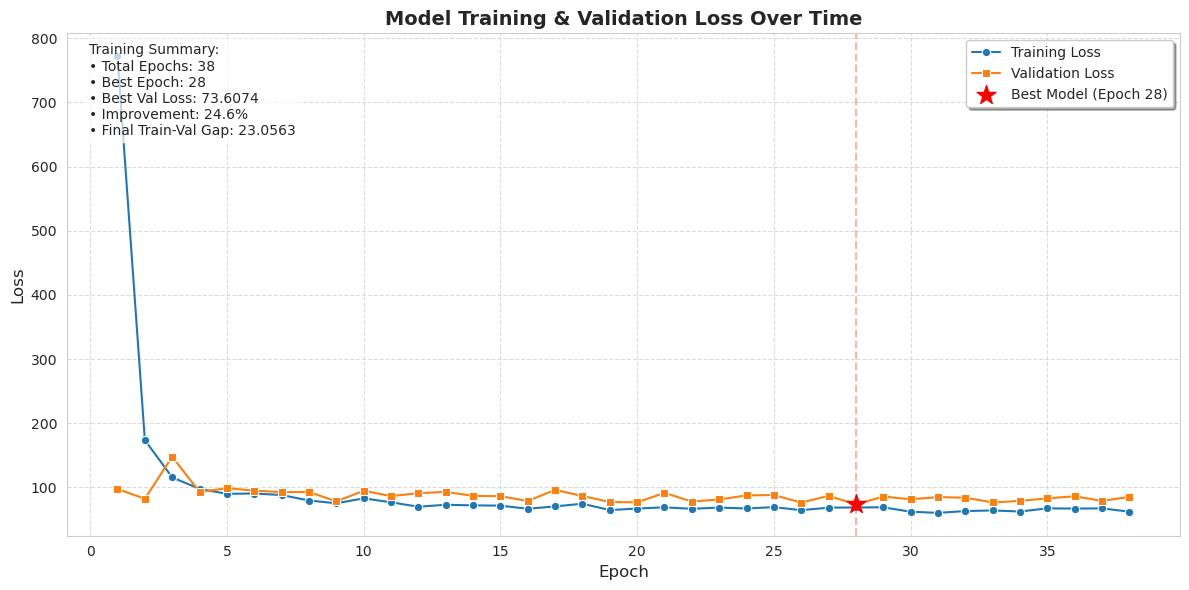

Figure saved to training_history.png


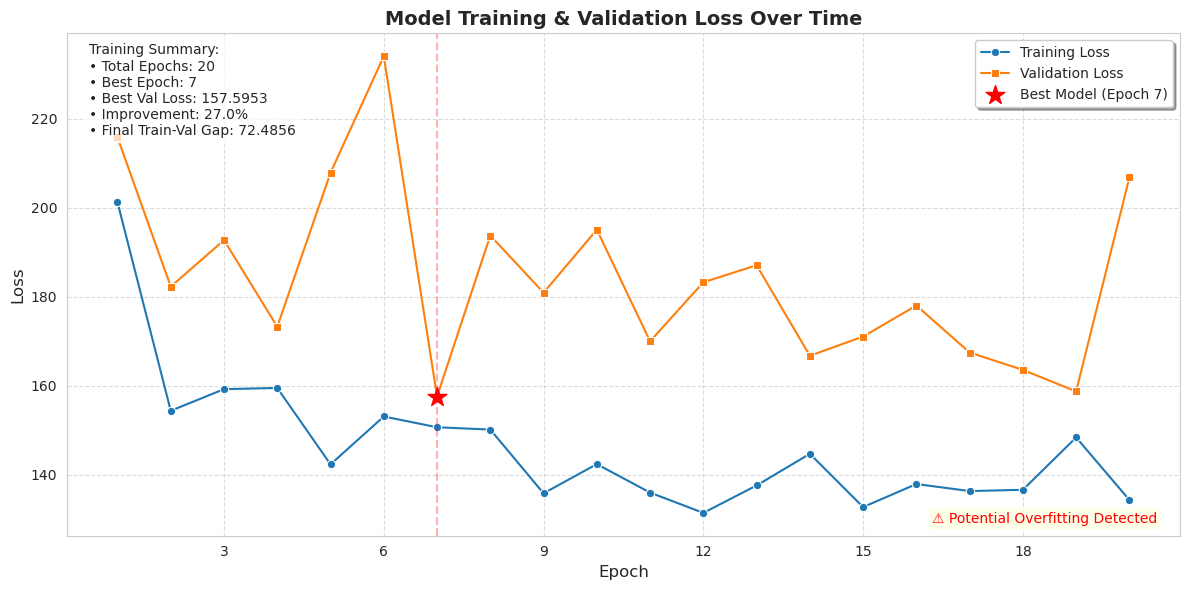

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_training_history(history, figsize=(12, 6), save_path=None):
    """
    Visualizes the training history with detailed plots and annotations.
    
    This function creates a comprehensive visualization of model training progress,
    showing both training and validation losses over epochs, with annotations
    highlighting important points in the training process.
    
    Args:
        history (dict): Dictionary containing 'train_loss' and 'val_loss' lists.
        figsize (tuple): Figure size as (width, height) in inches. Defaults to (12, 6).
        save_path (str, optional): Path to save the figure. If None, the figure is only displayed.
                                   Defaults to None.
    
    Returns:
        matplotlib.figure.Figure: The generated figure for further customization if needed.
    """
    # Set the visual style for the plots
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Convert data to DataFrame for easier manipulation
    epochs = range(1, len(history['train_loss']) + 1)
    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': history['train_loss'],
        'Validation Loss': history['val_loss']
    })
    
    # Plot the training and validation loss
    sns.lineplot(x='Epoch', y='Training Loss', data=df, marker='o', label='Training Loss', ax=ax)
    sns.lineplot(x='Epoch', y='Validation Loss', data=df, marker='s', label='Validation Loss', ax=ax)
    
    # Find the epoch with minimum validation loss
    min_val_loss_epoch = np.argmin(history['val_loss']) + 1
    min_val_loss = history['val_loss'][min_val_loss_epoch - 1]
    
    # Highlight the best model point
    ax.scatter(min_val_loss_epoch, min_val_loss, s=200, c='red', marker='*', 
               label=f'Best Model (Epoch {min_val_loss_epoch})', zorder=5)
    
    # Add annotations for key insights
    # Calculate the gap between training and validation loss
    final_gap = abs(history['train_loss'][-1] - history['val_loss'][-1])
    initial_gap = abs(history['train_loss'][0] - history['val_loss'][0])
    
    # Calculate improvement from first to best epoch
    improvement = (history['val_loss'][0] - min_val_loss) / history['val_loss'][0] * 100
    
    # Add a text box with training statistics
    textbox_props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    stats_text = (
        f"Training Summary:\n"
        f"• Total Epochs: {len(epochs)}\n"
        f"• Best Epoch: {min_val_loss_epoch}\n"
        f"• Best Val Loss: {min_val_loss:.4f}\n"
        f"• Improvement: {improvement:.1f}%\n"
        f"• Final Train-Val Gap: {final_gap:.4f}"
    )
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=textbox_props)
    
    # Add a vertical line at the best epoch
    ax.axvline(x=min_val_loss_epoch, color='red', linestyle='--', alpha=0.3)
    
    # Detect potential overfitting
    if len(epochs) > 3:  # Need enough epochs to detect a trend
        # Check if validation loss is increasing while training loss is decreasing
        val_trend = np.polyfit(epochs[-3:], history['val_loss'][-3:], 1)[0]
        train_trend = np.polyfit(epochs[-3:], history['train_loss'][-3:], 1)[0]
        
        if val_trend > 0 and train_trend < 0:
            ax.text(0.98, 0.02, "⚠️ Potential Overfitting Detected", 
                    transform=ax.transAxes, fontsize=10, color='red',
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    # Enhance plot formatting
    ax.set_title('Model Training & Validation Loss Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    
    # Format y-axis to avoid scientific notation
    ax.ticklabel_format(useOffset=False, style='plain')
    
    # Set x-axis to show integer epoch numbers
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Create a more descriptive and positioned legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Ensure layout fits well
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig


# Plot the training history
plot_training_history(low_quality_training_history, save_path="training_history.png")
plt.show()

plot_training_history(high_quality_training_history, save_path="training_history.png")
plt.show()


# Testing with already saved weights

In [8]:

# Test the low quality model
print("Testing the low quality model")
test_model(low_quality_predictor_trained, low_test_dataloader, criterion, device)
print("------------------")

# Test the high quality model
print("Testing the high quality model")
test_model(high_quality_predictor_trained, high_test_dataloader, criterion, device)
print("------------------")


Testing the low quality model


Test RMSE: 8.6956
------------------
Testing the high quality model
Test RMSE: 11.6135
------------------


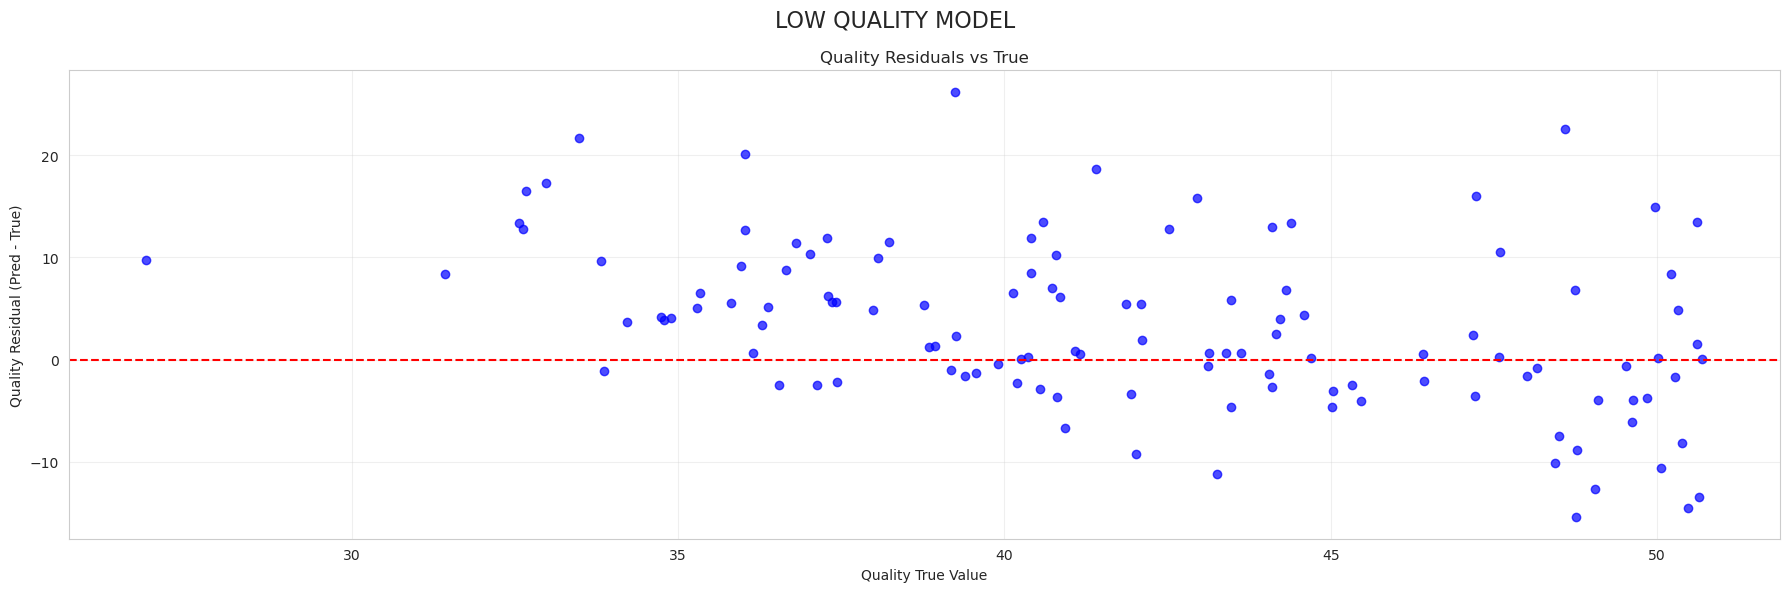

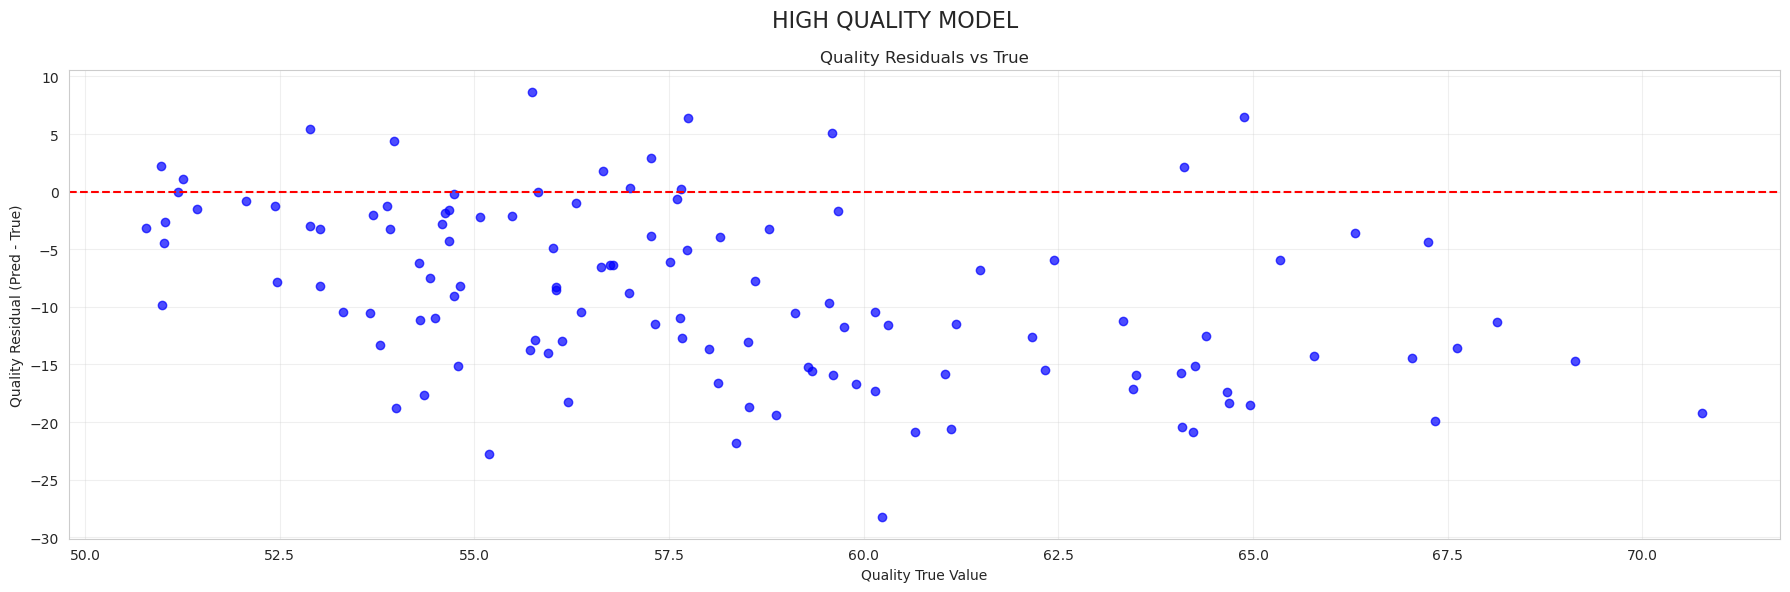

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.gridspec as gridspec


def compute_metrics(model, dataloader, device):
    """
    Computes metrics for model evaluation including residuals.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing predictions, ground truth, and calculated metrics
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Collect predictions and ground truth
    pred_list = []
    true_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            pred_list.append(outputs.cpu())
            true_list.append(labels)
    
    # Concatenate batches
    predictions = torch.cat(pred_list, dim=0).numpy()
    ground_truth = torch.cat(true_list, dim=0).numpy()
    
    # Extract quality and authenticity scores
    pred_quality = predictions
    true_quality = ground_truth
    
    # Calculate residuals (important for understanding distribution)
    quality_residuals = pred_quality - true_quality
    
    # Calculate correlation metrics for individual scores
    quality_spearman, q_pvalue = spearmanr(pred_quality, true_quality)
    
    # Calculate R² scores
    quality_r2 = r2_score(true_quality, pred_quality)
    
    
    # Calculate RMSE scores
    quality_rmse = np.sqrt(mean_squared_error(true_quality, pred_quality))
   
    # Create results dictionary
    results = {
        'predictions': {
            'quality': pred_quality,
        },
        'ground_truth': {
            'quality': true_quality,
        },
        'residuals': {
            'quality': quality_residuals,
        },
        'metrics': {
            'quality': {
                'spearman': quality_spearman,
                'p_value': q_pvalue,
                'r2': quality_r2,
                'rmse': quality_rmse
            }
        }
    }
    
    return results

def visualize_correlations(results, save_path=None, title=""):
    """
    Visualizes correlations and distributions from computed metrics.
    
    Args:
        results (dict): Results dictionary from compute_metrics function
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    # Extract data from results dictionary
    pred_quality = results['predictions']['quality']
    true_quality = results['ground_truth']['quality']
     
    quality_residuals = results['residuals']['quality']
    
    # Get metrics
    quality_metrics = results['metrics']['quality']
    
    # Create a larger figure with 3 rows and one column
    fig = plt.figure(figsize=(16, 18))
    fig.suptitle(title, fontsize=16)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
    
    # Create subplots
    ax_quality = plt.Subplot(fig, gs[0])
    ax_quality_res = plt.Subplot(fig, gs[1])
    ax_quality_hist = plt.Subplot(fig, gs[2])

    
    # Function to plot correlation scatter plot
    def plot_correlation(ax, true_vals, pred_vals, metrics, title_suffix):
        ax.scatter(true_vals, pred_vals, alpha=0.7, color='blue')
        
        # Add identity line
        min_val = min(min(true_vals), min(pred_vals))
        max_val = max(max(true_vals), max(pred_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
        
        # Add regression line
        z = np.polyfit(true_vals, pred_vals, 1)
        p = np.poly1d(z)
        x_sorted = np.sort(true_vals)
        ax.plot(x_sorted, p(x_sorted), 'g-', label=f'Best fit (y = {z[0]:.3f}x + {z[1]:.3f})')
        
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title(f'{title_suffix}\nSpearman ρ = {metrics["spearman"]:.4f}, R² = {metrics["r2"]:.4f}, RMSE = {metrics["rmse"]:.4f}')
        ax.grid(alpha=0.3)
        ax.legend(loc='upper left')
    
    # Function to plot residuals vs predicted
    def plot_residuals(ax, pred_vals, residuals, title_suffix):
        ax.scatter(pred_vals, residuals, alpha=0.7, color='orange')
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('Residual (Pred - True)')
        ax.set_title(f'{title_suffix} Residuals vs Predicted')
        ax.grid(alpha=0.3)
    
    # Function to plot residual histogram
    def plot_residual_hist(ax, residuals, title_suffix):
        ax.hist(residuals, bins=20, alpha=0.7, color='green')
        ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlabel('Residual Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{title_suffix} Residual Distribution')
        # Add mean and std as text
        mean_res = np.mean(residuals)
        std_res = np.std(residuals)
        ax.text(0.05, 0.95, f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Plot all charts
    plot_correlation(ax_quality, true_quality, pred_quality, quality_metrics, 'Quality Score')
    plot_residuals(ax_quality_res, pred_quality, quality_residuals, 'Quality') 
    plot_residual_hist(ax_quality_hist, quality_residuals, 'Quality')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    # Print summary statistics
    print("-" * 50)
    print(f"MODEL EVALUATION: {title}")
    print("-" * 50)
    print(f"Quality Score - Spearman ρ: {quality_metrics['spearman']:.4f} (p-value: {quality_metrics['p_value']:.4g}), R²: {quality_metrics['r2']:.4f}, RMSE: {quality_metrics['rmse']:.4f}")

def plot_correlations(model, dataloader, device, save_path=None, title=""):
    """
    Wrapper function that computes metrics and visualizes correlations.
    Maintains backward compatibility with the original function.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
        
    Returns:
        dict: Dictionary containing correlation metrics
    """
    # Compute metrics
    results = compute_metrics(model, dataloader, device)
    
    # Visualize results
    visualize_correlations(results, save_path, title)
    
    # Return metrics for backward compatibility
    return results['metrics']

def true_vs_error_plot(results, save_path=None, title=""):
    """
    Create a plot of the true scores vs. the prediction errors (residuals) for the model.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    
    # Extract residuals
    quality_residuals = results['residuals']['quality']
    
    # Create a figure with 1 subplot
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot residuals
    ax.scatter(results['ground_truth']['quality'], quality_residuals, alpha=0.7, color='blue')
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Quality True Value')
    ax.set_ylabel('Quality Residual (Pred - True)')
    ax.set_title('Quality Residuals vs True')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

def pred_vs_error_plot(results, save_path=None, title=""):
    """
    Create a plot of the true scores vs. the prediction errors (residuals) for the model.
    
    Args:
        model (nn.Module): The trained model to evaluate
        dataloader (DataLoader): Test dataloader containing images and true scores
        device (str): Device to run the model on ('cuda' or 'cpu')
        save_path (str, optional): Path to save the plot. If None, plot is displayed instead.
        title (str): Title for the plot
    """
    
    # Extract residuals
    quality_residuals = results['residuals']['quality']

    
    # Create a figure with 3 subplots
     # Create a figure with 1 subplot
    fig, ax = plt.subplots(1, 1, figsize=(6 , 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot residuals
    ax.scatter(results['predictions']['quality'], quality_residuals, alpha=0.7, color='blue')
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Quality Predicted Value')
    ax.set_ylabel('Quality Residual (Pred - True)')
    ax.set_title('Quality Residuals vs Predicted')
    ax.grid(alpha=0.3)
    


    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()



LOW_QUALITY_PATH_NAME = 'Plots/low_quality_correlations.png'
HIGH_QUALITY_PATH_NAME = 'Plots/high_quality_correlations.png'

low_quality_results = compute_metrics(low_quality_predictor_trained, low_test_dataloader, device)
high_quality_results = compute_metrics(high_quality_predictor_trained, high_test_dataloader, device)

true_vs_error_plot(low_quality_results,save_path="Plots/baseline_true_vs_error.png", title="LOW QUALITY MODEL")
true_vs_error_plot(high_quality_results,save_path="Plots/baseline_true_vs_error.png", title="HIGH QUALITY MODEL")

low_q_results = compute_metrics(low_quality_predictor_trained, low_test_dataloader, device)
high_q_results = compute_metrics(high_quality_predictor_trained, high_test_dataloader, device)





In [10]:
print(low_q_results['metrics']['quality'])
print(high_q_results['metrics']['quality'])




{'spearman': np.float64(0.24419751371623025), 'p_value': np.float64(0.007190939021120585), 'r2': -1.501298189163208, 'rmse': np.float64(8.695594145539758)}
{'spearman': np.float64(0.1287658865198972), 'p_value': np.float64(0.16102344156867004), 'r2': -5.401072978973389, 'rmse': np.float64(11.613486874861405)}
